## Data understanding

* target of competition is to build a binary text classification model
* CRISP-DM is selected as procedure model
* Generel assumption: Information contained in the trainset is sufficient to predict the target

* Insights already were optained by exploring the dataset - resulted in the following assumptions and decisions:
*  the training dataset has a highly unqueal class dictribution. Only about 6.4% of all questions are labled as insincere: EDA: https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
* Consequences of this fact below

#### Import libraries

In [1]:
# General
import pandas as pd
import numpy as np
import os

# Preprocessing
import re
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Modeling
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Training
from sklearn.model_selection import StratifiedKFold
  # splits train-set into into train and validation folds
    
# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


Using TensorFlow backend.


#### Hyperparameters

In [2]:
# Fast Run Testing
#total_train_samples = 1000 # max is 1306122
#total_test_samples = 2000 # max is 375806
total_train_samples = 1306122 # max is 1306122
total_test_samples = 375806 # max is 375806

# Preprocessing
maxlen = 100 # max seuquence length (max 100 words of each question is used)
max_words = 10000 # only 10k most frequent are used to create the vocabulary

# Modeling
embedding_dim = 300 # set to 300 to be able to compare with pre-trained embeddings

# Training
kfolds = 3
model_epochs = 10


## Load Data

In [3]:
df = pd.read_csv("../input/train.csv")
str_ = 'Train data loaded'
os.system('echo '+str_)

0

In [4]:
df = df[:total_train_samples] # for Testing purposes
num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

X = df.loc[:, 'question_text'].values
y = df.loc[:, 'target'].values

# Neural Networks are only able to perform transformations on tensors 
y = np.asarray(y) # Transformation target labels to numpy array 

print('Shape data tensor:', X.shape) 
print('Shape target tensor:', y.shape) # 1D Tensor

pd.set_option('display.max_colwidth', 1500) # inrease display column size
df.head(3)

Shape for this run:  1306122 3
Shape data tensor: (1306122,)
Shape target tensor: (1306122,)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0


## Preprocessing

* w/o data cleaning
* tokenisation only

#### Tokenization

In [5]:
def my_tokenizer(texts):
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(texts) 
        sequences = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(sequences, maxlen=maxlen)  
        word_index = tokenizer.word_index  
        
        return padded_seq, word_index

print("First sentence without tokenization: \n", X[0])
print("\nFirst sentence tokenized: \n",  my_tokenizer(X[[0]])[0])

First sentence without tokenization: 
 How did Quebec nationalists see their province as a nation in the 1960s?

First sentence tokenized: 
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9
  10 11 12 13]]


In [6]:
# Apply tokenization on whole dataset
padded_seq, word_index = my_tokenizer(X)
print("Found {} unique tokens".format(len(word_index)))

# Show first 10 words in the dictionary with their corresponding index
for word, index in word_index.items():
    if index < 10:
        print(word, index)

Found 222161 unique tokens
the 1
what 2
is 3
a 4
to 5
in 6
of 7
i 8
how 9


## Load Embeddings and Create Embedding-matrix

#### Load GloVe-Embedding



In [7]:
str_ = 'Loading Embedding...'
os.system('echo '+str_)

0

In [8]:
embeddings_dict = {} # create empty embedding dictionary
# Open glove file (vector size 300!)
embedding_file = open('../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec')

# Fill embedding dict with word: vector(coefs) pairs
for line in embedding_file:
    line_values = line.split(' ') # read in values of respective line (= vector)
    word = line_values[0] #  # first value in line represents the word
    coefs = np.asarray(line_values[1:], dtype='float32') 
      # # all other values in line represent the word vector
    embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

embedding_file.close() 

str_ = 'Embedding Loaded!'
os.system('echo '+str_)
print('Embedding loaded')
print('{} word vectors within embeddings_dict.'.format(len(embeddings_dict)))

Embedding loaded
999995 word vectors within embeddings_dict.



#### Creation Embedding Matrix
 
*     embeddings_dict now contains about 2.2 million words with corresponding vector representation
*     However not all these word: vector pairs are needed
*     A word representation from the embedding only has to be found for the most frequent 10.000 word within the text corpus (= the questions)
*     These 10k words already are contained within word_index dict which was created earlier
*     In the following code a embedding matrix is created for the 10k words
* Moreover words are counted for which an embedding is not found 


In [9]:
embedding_dim = 300 # (vector size 300!)
# Creation empty matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
known_words_list = []
unknown_words_list = []

# Filling up matrix
for word, i in word_index.items(): 
        # in index data is stored: {word:index, word_index, ..}
    if i < max_words: # only use 10k most frequent words
        embedding_vector = embeddings_dict.get(word) 
          # get vector for word from embedding
        if embedding_vector is not None:
            known_words_list.append(word)
            embedding_matrix[i] = embedding_vector
        else:
            unknown_words_list.append(word)
            
            
              # implies that word that are not found get zero vector
                
print('Embeddings_matrix created')
print('  Shape embedding_matrix: {}'.format(embedding_matrix.shape))
print('Found Embeddings for {:.2f}% of all words'.format((len(known_words_list) / max_words)*100))
print('Unknown Words: {:.2f}%'.format((len(unknown_words_list) / max_words)*100))

# Top 10 unknown words
unknown_words_list[:10]

Embeddings_matrix created
  Shape embedding_matrix: (10000, 300)
Found Embeddings for 97.23% of all words
Unknown Words: 2.76%


["don't",
 "what's",
 "i'm",
 "can't",
 "doesn't",
 "it's",
 "isn't",
 "didn't",
 "i've",
 'i’m']

## Modeling

* starting with a simple neural network
* model is encapsulated into a function for clarity reasons and to make model easier for later submission 
* literature recommends not to use pre-trained embeddings in case of the availability of a large dataset. 1.3 million questions are available in the train-set, which should be worth a try. The Embedding Layer tries to derive optimal vectors for the input words. After training the weights of the Embedding Layer represent these vectors.
* state-of-the-art loss function for binary classification tasks: **binary_crossentropy**
* **optimizer rmsprop** is in most-cases a good choice according to current research literature
* using the default learning rate of rmsprop is recommended and applied here

In [10]:
def get_keras_model():
    model = Sequential()
    model.add(Embedding(input_dim = max_words, # 10k different words/integers
                        output_dim = embedding_dim, 
                        input_length = maxlen)) # seqeuence length 100

    model.add(Flatten()) # reduction 3D tensor(embedding output) to 2D tensor
    model.add(Dense(32, activation='relu')) 
    model.add(Dense(1, activation='sigmoid')) # final -  binary classifier
    
    model.layers[0].set_weights([embedding_matrix]) 
    # Setting weights not trainable 
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

get_keras_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 960,065
Non-trainable params: 3,000,000
_________________________________________________________________


### Training + Evaluation

* Input for model are batches of sequences
        * Input shape: 2D tensor(matrix): (batch_size, sequence_length).
* each sequence has a maximum length of maxlen (here: 100)
* Embedding Layer translates Integers of each sequence into dense vectors
  (comp. https://keras.io/layers/embeddings/)
      * input_length: Length of input sequence
* embedding_matrix translates integers into into 3D Tensores of shape:
      * Output shape: (batch_size, sequence_length, output_dim)


* accuracy metric is not suitable is cases target classes are quite unequal distributed
* ROC-AUC also not applicable for the same reason
* Suitable Evaluation metrics: Precision, Recall and F1-Score as combination of both. Since these metric functions were removed in Keras 2.0, they are implemented within an own callback below. # class based on:
https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2


In [11]:

class CustomMetric(Callback):

    # Creatin Instance ata the beginning of each epoch
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    
    # Function called at the end of ery epoch
    def on_epoch_end(self, epoch, logs={}):
        # as a start simple round function as threshold
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_target = self.validation_data[1]
        
        _val_f1 = f1_score(y_true = val_target, y_pred = val_predict)
        _val_recall = recall_score(y_true = val_target,y_pred = val_predict)
        _val_precision = precision_score(y_true = val_target,y_pred = val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        # print("— val_f1: {} — val_precision: {} — val_recall {}".format(_val_f1, _val_precision, _val_recall))
        #print(precision_recall_fscore_support(val_target, val_predict, average = 'binary'))
        if epoch%2 == 0:
            print("  -- epoch: {}".format(epoch))
        return

* StratifiedKFold: training is performed "kfold"- time, within each fold several epochs are run.

In [12]:
# fold_list contains train and validation indices (folds) for each split
folds = list(StratifiedKFold(n_splits=kfolds, shuffle= True, random_state=123)
             .split(padded_seq, y))

my_metrics = [] # list to collect metrics at the end of each split
my_y_val_preds = {} # dictionary to collect model predictions at the end of each split
my_y_val_targets = {} # dictionary of true classes at the end of each split
best_f1_dict = {}
best_threshold_dict = {}
my_history_dict = {}
my_metrics_dict = {}
for i, (train_indices, val_indices) in enumerate(folds):
    
    print('\nSplit: {}  \n '.format(i))
    str_ = 'Training with Fold: '
    os.system('echo '+ str_ + str(i)) # monitor training process in log
    
    X_train, X_val = padded_seq[train_indices], padded_seq[val_indices] 
    y_train, y_val = y[train_indices], y[val_indices] 

    model = get_keras_model() # create new model for current split
    my_metrics = CustomMetric() # create new metrics instance
 
    # Training process is logged in history object for visualition purposes
    # within each split setting the model is trained several epochs (complete fit)
    history = model.fit(X_train, y_train,
                        epochs = model_epochs, 
                        batch_size= 32,
                        verbose = 0, 
                        validation_data=(X_val, y_val),
                        callbacks = [my_metrics])
    my_history_dict[i] = history
    my_metrics_dict[i] = my_metrics
    
    y_val_pred = model.predict(X_val) # prediction on 
    my_y_val_preds[i] = y_val_pred 
    my_y_val_targets[i] = y_val
    
    # Find best threshold for prediction
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0.1,0.5, 0.01):
        # calucate f1 score for allowed thresholds
        f1_score_threshold = f1_score(y_true = y_val ,
                                              y_pred = y_val_pred > threshold) # 0 or 1
        if f1_score_threshold > best_f1:
            best_f1 = f1_score_threshold
            best_threshold = threshold
            best_f1_dict[i] = best_f1
            best_threshold_dict[i] = best_threshold



Split: 0  
 
Instructions for updating:
Use tf.cast instead.
  -- epoch: 0
  -- epoch: 2
  -- epoch: 4
  -- epoch: 6
  -- epoch: 8

Split: 1  
 
  -- epoch: 0
  -- epoch: 2
  -- epoch: 4
  -- epoch: 6
  -- epoch: 8

Split: 2  
 
  -- epoch: 0
  -- epoch: 2
  -- epoch: 4
  -- epoch: 6
  -- epoch: 8


In [13]:


thresh_avg = 0
thresh_sum = 0
f1_avg = 0
f1_sum = 0
for key, value in best_f1_dict.items():
    print("Split: {} : Best F1 score: {:6.4f} reached with a threshold of {:6.4f}"
          .format(key, best_f1_dict[key], best_threshold_dict[key]))
    thresh_sum += best_threshold_dict[key] 
    thresh_avg = thresh_sum/kfolds
    f1_sum += best_f1_dict[key] 
    f1_avg = f1_sum/kfolds
   
print("")
print("Threshold for prediction: {:6.4f}".format(thresh_avg))
print("Average F1-Score: {:5.3f}".format(f1_avg))



Split: 0 : Best F1 score: 0.5275 reached with a threshold of 0.3000
Split: 1 : Best F1 score: 0.5305 reached with a threshold of 0.2500
Split: 2 : Best F1 score: 0.5276 reached with a threshold of 0.2300

Threshold for prediction: 0.2600
Average F1-Score: 0.529


## Evaluation

* For the evaluation of unbalanced datasets the accuracy as e.g. implemented in SKLEARN's function cross_val_score() is NOT recommended
* A high F1 score is the target in this competition


Split: 0 


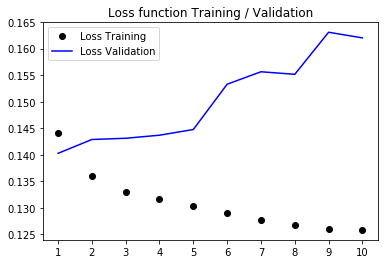

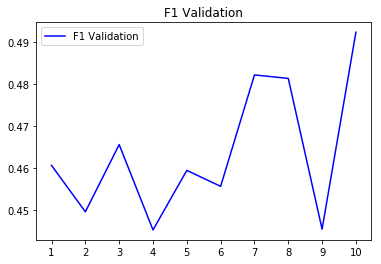

Split: 1 


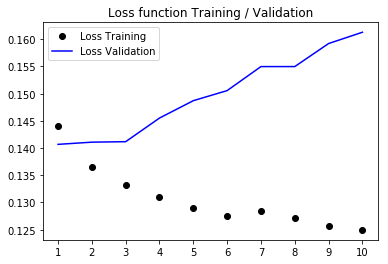

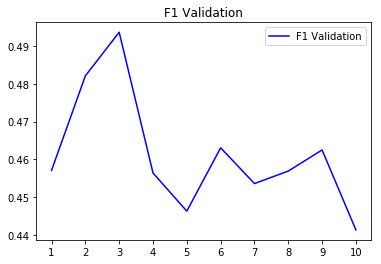

Split: 2 


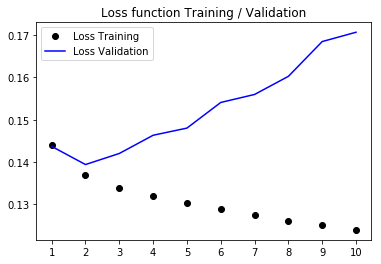

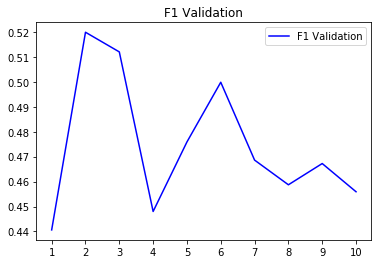

In [14]:
for hist in my_history_dict:
    
    print('Split: {} '.format(hist))
    loss = my_history_dict[hist].history['loss']
    val_loss = my_history_dict[hist].history['val_loss']
    epochs = np.arange(1, len(loss) +1, 1) # x-axis

    plt.figure()
    plt.xticks(epochs)
    plt.plot(epochs, loss, 'bo', label='Loss Training', color = 'black')
    plt.plot(epochs, val_loss, 'b', label='Loss Validation')
    plt.title('Loss function Training / Validation')
    plt.legend()
 
    val_f1 = my_metrics_dict[hist].val_f1s
    plt.figure()
    plt.xticks(epochs)
    plt.plot(epochs, val_f1, 'b', label='F1 Validation')
    plt.title('F1 Validation')
    plt.legend()
    
    plt.show()